In [1]:
import numpy as np
import pandas as pd

from Datasets.utk_face import UTKFaceDataset

#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

import copy

In [2]:
# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [3]:
# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 16

# Number of channels in the training images. For color images this is 3
nc = 3

# Number of training epochs
num_epochs = 300

# Number of epochs of increasing validation loss to wait before early stopping
patience = 15

# Learning rate for optimizers
lr = 0.0002

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Create the dataloader
dataloader = torch.utils.data.DataLoader(UTKFaceDataset(), batch_size=batch_size,
                                        shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("mps")

torch.Size([16, 3, 200, 200])


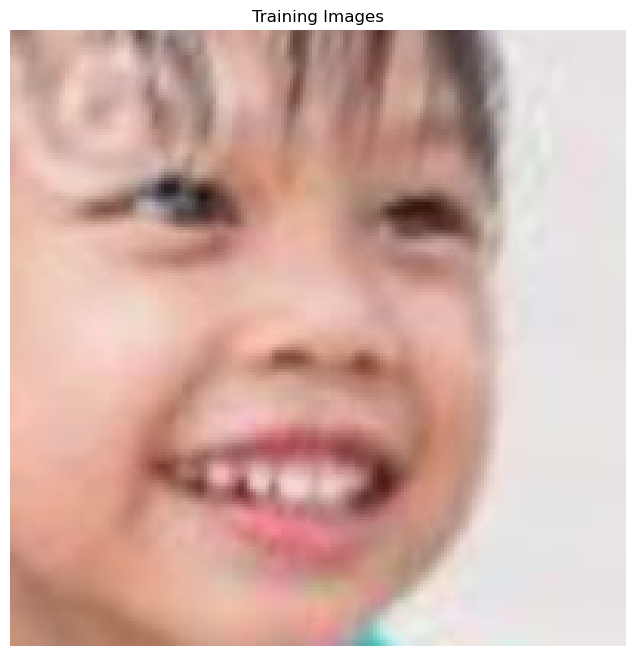

In [4]:
# Plot some training images
images, label = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
print(images.shape)
plt.imshow(np.transpose(vutils.make_grid(images[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))
plt.show()

In [5]:
layers = [
    nn.Conv2d(3, 16, 6, stride=2),
    nn.LeakyReLU(),
    nn.Conv2d(16, 8, 4, stride=2),
    nn.LeakyReLU(),
    nn.Conv2d(8, 4, 4, stride=2),
    nn.LeakyReLU(),

    nn.Flatten(),
    nn.LazyLinear(1024),
    nn.ReLU(),
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 4),
    nn.ReLU(),
    nn.Linear(4, 1)
]

scorer = nn.Sequential(*layers).to(device)

/opt/homebrew/anaconda3/envs/VAE/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
from Models.vae import Variational

z = 1024
layers = [
    nn.Conv2d(3, 16, 6, stride=2),
    nn.LeakyReLU(),
    nn.Conv2d(16, 8, 4, stride=2),
    nn.LeakyReLU(),
    nn.Conv2d(8, 4, 4, stride=2),
    nn.LeakyReLU(),

    nn.Flatten(),
    nn.LazyLinear(z),
    nn.ReLU(),
    nn.Linear(z, z),
    Variational(z, z)
]

from Models.vae import Autoencoder
model = Autoencoder(layers).to(device)

In [7]:
def BPR_loss(images_score, recon_score):
    return (torch.mean(torch.sign(images_score - recon_score)) + 1) / 2

In [8]:
def score_loss(images_score, recon_score):
    return torch.mean(torch.square(images_score - recon_score))

In [9]:
best_model, best_loss = None, np.inf
epochs_waited = 0

def KL_standard_normal(mean, std):
    return torch.mean(- torch.log(std) + (torch.square(std) + torch.square(mean) - 1) / 2)

def criterion(images, recon, images_score, recon_score, mean, std):
    recon_loss = nn.functional.mse_loss(images, recon) + score_loss(images_score.detach(), recon_score.detach()) + 0.003 * KL_standard_normal(mean, std)

    return recon_loss

score_criterion = BPR_loss

optimizer = optim.Adam(model.parameters(), lr=lr)
score_optimizer = optim.Adam(scorer.parameters(), lr=lr)
history = []

def step():
    images, labels = next(data_iter)

    images = images.to(device)
    labels = labels.to(device)

    recon, mean, std = model(images)

    images_score, recon_score = scorer(images.detach()), scorer(recon.detach())

    loss = criterion(images, recon, images_score, recon_score, mean, std)

    scorer_loss = score_criterion(images_score, recon_score)

    return loss, scorer_loss

train_batches = 100
valid_batches = 20
for epoch in range(num_epochs):
    data_iter = iter(dataloader)

    total_train_loss = 0
    for batch in range(train_batches):

        optimizer.zero_grad()
        score_optimizer.zero_grad()

        loss, scorer_loss = step()

        loss.backward()
        optimizer.step()
        
        scorer_loss.backward()
        score_optimizer.step()

        total_train_loss += loss.item() * batch_size
    
    train_loss = total_train_loss / (batch_size * train_batches)
    print("Train loss:", train_loss)

    total_valid_loss = 0
    for batch in range(train_batches, train_batches+valid_batches):
        loss, scorer_loss = step()

        total_valid_loss += loss.item() * batch_size

    valid_loss = total_valid_loss / (batch_size * valid_batches)
    print("Valid loss:", valid_loss)

    epochs_waited += 1
    if (valid_loss < best_loss):
        best_loss = valid_loss
        best_model = Autoencoder(layers)
        best_model.load_state_dict(model.state_dict())
        epochs_waited = 0

    if (epochs_waited > patience):
        break

    history.append((train_loss, valid_loss))

model = best_model
    
    

Train loss: 0.08715807834267617
Valid loss: 0.050437229499220845
Train loss: 0.047686188831925394
Valid loss: 0.044767992570996284
Train loss: 0.04630555786937475
Valid loss: 0.0442322101444006
Train loss: 0.04360269022732973
Valid loss: 0.04467790871858597
Train loss: 0.04241506195813417
Valid loss: 0.04899117834866047
Train loss: 0.042330606445670126
Valid loss: 0.035879135504364966
Train loss: 0.03626091860607267
Valid loss: 0.03457872532308102
Train loss: 0.03526345917582512
Valid loss: 0.032874894328415394
Train loss: 0.035058459140360355
Valid loss: 0.03320540636777878
Train loss: 0.03198826062679291
Valid loss: 0.029718350060284136
Train loss: 0.028917319629341364
Valid loss: 0.029447809979319572
Train loss: 0.02894031922519207
Valid loss: 0.02840891946107149
Train loss: 0.02793736394122243
Valid loss: 0.028990540094673632
Train loss: 0.026993431247770785
Valid loss: 0.026604503765702246
Train loss: 0.026702923104166984
Valid loss: 0.028033032827079297
Train loss: 0.026359225261

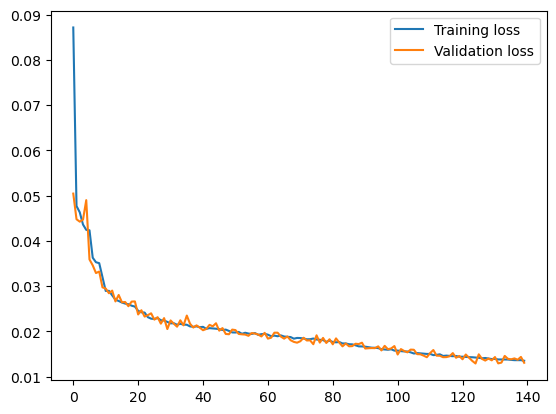

In [10]:
plt.plot(history)
plt.legend(["Training loss", "Validation loss"])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


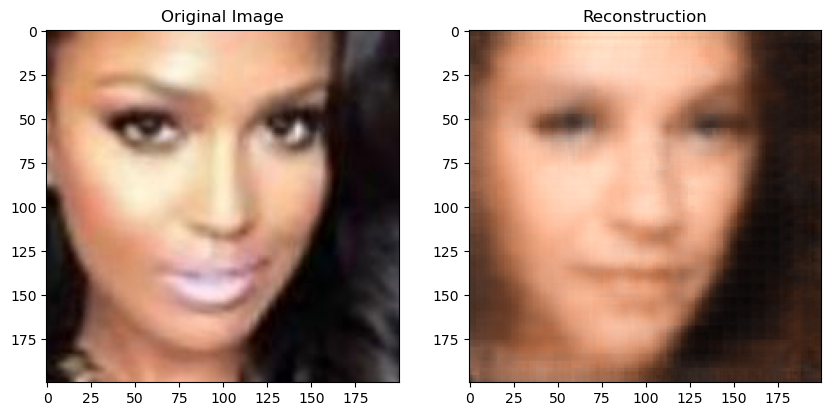

In [16]:
# Plot some training images
images, label = next(data_iter)
plt.figure(figsize=(10,5))
plt.axis("off")
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(np.transpose(vutils.make_grid(images[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))

with torch.no_grad():
    recon, mean, std = model(images.to(device))

plt.subplot(1,2,2)
plt.title("Reconstruction")
plt.imshow(np.transpose(vutils.make_grid(recon[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))
plt.show()